In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import ipywidgets
import ipywidgets as widgets
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import os 
import pandas as pd
import json

In [10]:
#Setting plots parameters
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size']= 12
plt.style.use("seaborn-colorblind")

# Introduction
This notebook allows to analyse stress relaxation data obtained from the Chiaro/Piuma/ nanoindenters from Optics 11 Life. It is divided into several sections that should be ran in order. The notebook runs ipywidgets to make it more user friendly for non-programmers.
This is a work in progress and the notebook is at a very early stage. Please feel free to report any bugs and improvements!


## 1) Functions
This is the "backend" and needs only to be ran, but not modified.

In [4]:
def get_files(dir_path,ext=".txt"): #edit to be JSON so that cleaned file from nanopreapre can be read! 
    """Gets files from one directory and stores them into a list."""
    files_list = [] #list of file names
    files_dir = [] #list of file directories
    for root, dirs, files in os.walk(dir_path):
        for name in files:
        #get only txt files but exclude position.txt
            if ext==".txt":
                if name.endswith(ext) and not name.endswith('position.txt'):
                    files_list.append(name)
                    files_dir.append(os.path.join(root, name))
            else:
            #for other extensions, do not exclude files
                if name.endswith(ext):
                    files_list.append(name)
                    files_dir.append(os.path.join(root, name))
    return files_list, files_dir




def read_file(f): 
    """
    Reads one .txt file 
    """
    with open(f, encoding='utf-8', errors='ignore') as dynamic:
        stopLine = 'Time (s)'
        numeric = False
        data = []
        for riga in dynamic:
            if numeric is False:
                if riga[0:len(stopLine)] == stopLine:
                    numeric = True
            else:
                line = riga.strip().replace(',', '.').split('\t')
                # Time (s) Load (uN) Indentation (nm) Cantilever (nm) Piezo (nm) Auxiliary
                # skip  #5 auxiliary if present
                data.append([float(line[0]), float(line[1])*1000.0, float(line[2]),
                            float(line[3]), float(line[4])])
        data = np.array(data)
    return data

def getMedCurve(xar, yar,loose=True, threshold=3, error=False):
    """
    Takes repeated nummerical data (replicates stored in a multi dimensional list) 
    and computes the average and error. Useful for displaying "average" plots
    with error bands.
    This function was taken from the following github repo (https://github.com/CellMechLab/nanoindentation),
    author Dr Massimo Vassalli at the Cellular Mechanobiology Lab, University of Glasgow.
    """
    if loose is False:
        xmin = -np.inf
        xmax = np.inf
        deltax = 0
        nonecount = 0
        for x in xar:
            if x is not None and np.min(x) is not None:
                xmin = np.max([xmin, np.min(x)])
                xmax = np.min([xmax, np.max(x)])
                deltax += ((np.max(x)-np.min(x))/(len(x)-1))
            else:
                nonecount += 1
        deltax /= (len(xar)-nonecount)
        xnew = np.linspace(xmin, xmax, int((xmax-xmin)/(deltax)))
        ynew = np.zeros(len(xnew))
        for i in range(len(xar)):
            if xar[i] is not None and np.min(xar[i]) is not None:
                ycur = np.interp(xnew, xar[i], yar[i])
                ynew += ycur
        ynew /= (len(xar)-nonecount)
    else:
        xmin = np.inf
        xmax = -np.inf
        deltax = 0
        for x in xar:
            try:
                xmin = np.min([xmin, np.min(x)])
                xmax = np.max([xmax, np.max(x)])
                deltax += ((np.max(x) - np.min(x)) / (len(x) - 1))
            except TypeError:
                return
        deltax /= len(xar)
        xnewall = np.linspace(xmin, xmax, int((xmax - xmin) / deltax))
        ynewall = np.zeros(len(xnewall))
        count = np.zeros(len(xnewall))
        ys = np.zeros([len(xnewall), len(xar)])
        for i in range(len(xar)):
            imin = np.argmin((xnewall - np.min(xar[i])) ** 2)  # +1
            imax = np.argmin((xnewall - np.max(xar[i])) ** 2)  # -1
            ycur = np.interp(xnewall[imin:imax], xar[i], yar[i])
            ynewall[imin:imax] += ycur
            count[imin:imax] += 1
            for j in range(imin, imax):
                ys[j][i] = ycur[j-imin]
        cc = count >= threshold
        xnew = xnewall[cc]
        ynew = ynewall[cc] / count[cc]
        yerrs_new = ys[cc]
        yerr = []
        for j in range(len(yerrs_new)):
            squr_sum = 0
            num = 0
            std = 0
            for i in range(0, len(yerrs_new[j])):
                if yerrs_new[j][i] != 0:
                    squr_sum += (yerrs_new[j][i] - ynew[j]) ** 2
                    num += 1
            if num > 0:
                std = np.sqrt(squr_sum / num)
            yerr.append(std)
        yerr = np.asarray(yerr)
    if error == False:
        return xnew[:-1], ynew[:-1]
    elif error == True:
        return xnew[:-1], ynew[:-1], yerr[:-1]

def get_times_DMA(f):
    """
    Returns touple of arrays with start and end times of DMA sweeps
    """
    with open(f, encoding='utf-8', errors='ignore') as dynamic:
        target_start = 'DMA absolute start times (s)'
        target_end = 'DMA absolute end times (s)'
        for riga in dynamic:
            if riga[0:len(target_start)]==target_start:
                good_start = riga[len(target_start):].strip()
                better_start = list(map(float, good_start.split(',')))
            if riga[0:len(target_end)]==target_end:
                good_end = riga[len(target_end):].strip()
                better_end = list(map(float, good_end.split(',')))
    return better_start, better_end

def ft_relax(g, t, g_0=1, g_dot_inf=0, N_f=100, interpolate=True, oversampling=10):
    """ Calculates the Fourier transform of numeric data.

    Takes any numeric time-dependent function g(t) that vanishes fot t<0,
    sampled at finite points [g_k,t_k] with k=1...N, and returns its 
    Fourier transform g(omega), together with the frequency range omega 
    defined from 1/t_max to 1/t_min. For details on the numerical procedure,
    refer to Tassieri et al., 2016 (https://doi.org/10.1122/1.4953443).

    Parameters
    ---------
    g : array 
        measured time-dependent variable.
    t : array 
        time array. 
    g_0: 
        value of g at time euqal 0. Can be taken as g[0].
    g_dot_inf:
        value of the time derivative of g at time equal infinity. Can be taken as 0.
    N_f: int
        frequency samples.
    interpolate: bool
        if True, data is interpolated with a cubic spline and re-sampled in log-space.
    oversampling: int
        factor by which the length of the time array is increased for oversampling in log-space.
    """
    g = np.array(g)
    t = np.array(t)

    if interpolate is True:
        gi = interp1d(t, g, kind='cubic', fill_value='extrapolate')
        t_new = np.logspace(min(np.log10(t)), max(np.log10(t)), len(
            t)*oversampling)  # re-sample t in log space
        g = gi(t_new)  # get new g(t) taken at log-space sampled t
        t = t_new
    i = complex(0, 1)
    min_omega = 1/max(t)
    max_omega = 1/min(t)
    N_t = len(t)
    omega = np.logspace(np.log10(min_omega), np.log10(max_omega), N_f)
    zero = i*omega*g_0 + (1-np.exp(-i*omega*t[1]))*((g[1]-g_0)/t[1])\
        + g_dot_inf*np.exp(-i*omega*t[N_t-1])
    res = np.zeros(len(omega), dtype=complex)
    for w_i, w in enumerate(omega):
        after = 0
        for k in range(2, N_t):
            after += ((g[k] - g[k-1]) / (t[k] - t[k-1])) * (np.exp(-i * w *
                                                                   t[k-1])-np.exp(-i * w * t[k]))
        res[w_i] = (zero[w_i]+after)
    return omega, ((res)/(i*omega)**2)  # is omega Hz or rad/s

# Input Data 
Below, input the directory to the cleaned JSON file originating from NanoPrepare. 

In [5]:
#Please enter directory in the quotes
dirw=widgets.Text(
    value='',
    placeholder='Please enter the files directory',
    description='Directory:',
    disabled=False
)
display(dirw)

Text(value='', description='Directory:', placeholder='Please enter the files directory')

The following cell is just a check to verify the correct data is being read.

# Screening 
The plot below serves to *select* the thresholds for screening and aligning curves. This section is used only to selct the threshold; the actual data is thresholded in the next section (**Adjusting**) if the "Threshold" checkbox is checked. The data can be thresholded based on the following thresholds: 

1. tmin (s): the time under which the maximum force should occur. Any curve whose maximum force occurs after this time is discarded from the analysis. 
2. tmax (s): the maximum time one wants to display and analyse the data for. This is used to essentially remove the ramping down of the stress relaxation curve. Alla data points after this time are discarded.
3. fmin (uN): the minimum acceptable value for the maximum (peak) force. Any curve whose maximum force is smaller than fmin will be discarded.
4. fmax (uN): the maximum acceptable value for the maximum (peak) force. Any curve whose maximum force is greater than fmax will be discarded.

tip: adjust the sliders by typing the approximate value for the variable in the box next to the slider and click enter on your keyboard. Just sliding will update the plot for each value the slider passes through, resulting in a laggy visual update.

In [18]:
f = open(dirw.value)
data = json.load(f)
def first_plot(tmin=0.5,tmax=30.0,fmin=0.0,fmax=50.0):
    fig,ax=plt.subplots(1,2,figsize=(8,3))
    tall = []
    fall = []
    for i in range(len(data['curves'])):
        raw_time = np.array(data['curves'][i]['raw_data']['raw_time'])
        raw_force = np.array(data['curves'][i]['raw_data']['raw_force'])
        for_force = np.array(data['curves'][i]['data']['F']) #for = forward segment
        for_Z = np.array(data['curves'][i]['data']['Z'])
        
        #Offset force-time curves 
        off = raw_force[0] #first point
        #if forst point is negative, align
        if off <0: 
            raw_force = raw_force-off
        else:
            raw_force = raw_force
        
        #Offset F-z forward curves
        for_off = for_force[0]
        
        if for_off <0: 
            for_force = for_force-for_off
        else:
            for_force= for_force
    
        ax[0].plot(raw_time,raw_force,alpha=1,lw=0.1,c='k')
        ax[1].plot(for_Z,for_force, lw=0.1,c='k')
        ax[0].axhline(fmin,c="salmon",lw=1)
        ax[0].axhline(fmax,c="salmon",lw=1)
        ax[0].axvline(tmax,lw=1)
        ax[0].axvline(tmin,lw=1)
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('force (uN)')
    ax[1].set_ylabel('force (N)')
    ax[1].set_xlabel('Z (m)')
    fig.tight_layout()
    plt.show()
plot1w=widgets.interactive(first_plot,tmin=(0.0,50.0,0.5), tmax=(0.0,100.0,0.5),fmin=(0.0,100.0,0.1),fmax=(0.0,1500.0,0.1))
display(plot1w)

interactive(children=(FloatSlider(value=0.5, description='tmin', max=50.0, step=0.5), FloatSlider(value=30.0, …

# Adjusting
Now click the "Threshold" checkbox if you want to apply the above-specified thresholds to the data.

Given the above specified thresholds, the code below finds the maximum force and corresponding time and aligns this value to 0. All curves should now start from t=0. Note that the maximum time displayed will be different from the one selected above as curves are shifted by the time at which the maximum force occurs (however relative time interval is preserved)!

In the end, the average curve is plotted (red) on top of the individual curves (black).

In [25]:
thresholdw=widgets.Checkbox(
    value=False,
    description='Threshold data',
    disabled=False
)

display(thresholdw)

Checkbox(value=False, description='Threshold data')

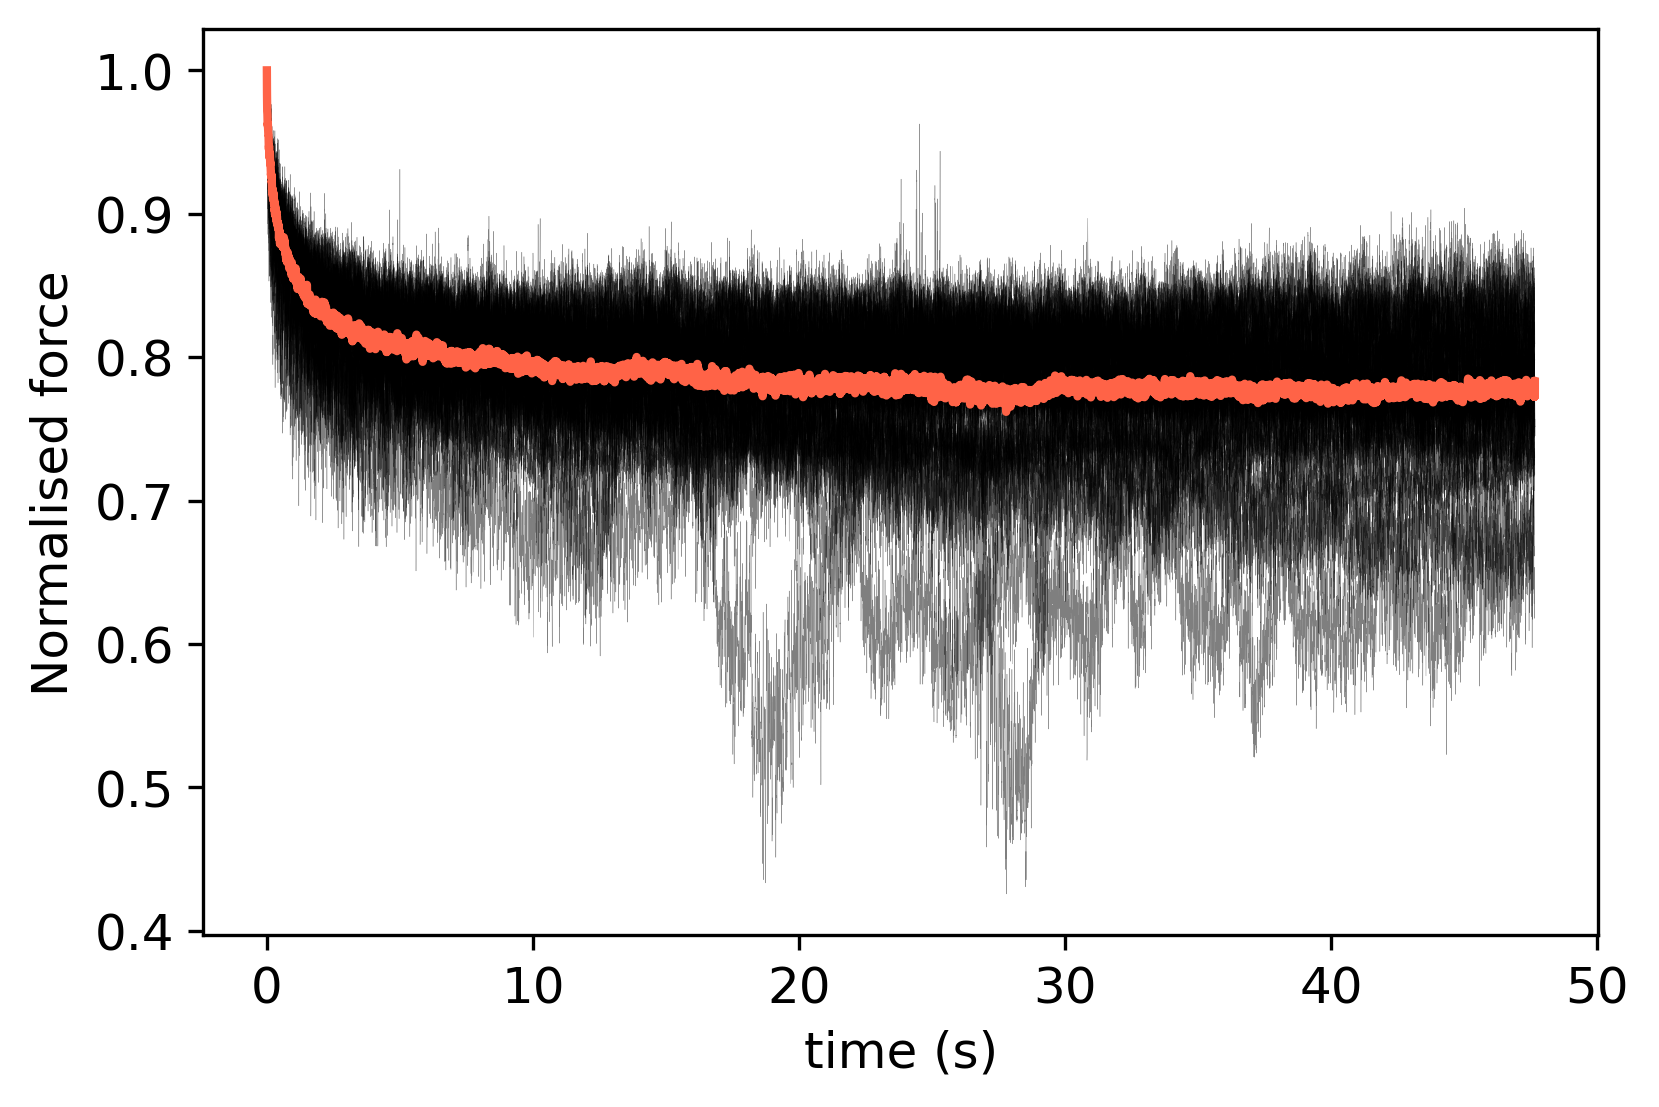

In [27]:
#Widget parameters (Global thresholds)
t_min=plot1w.kwargs["tmin"] #s #time under which max force should occur
t_max=plot1w.kwargs["tmax"] #s #max time to display and analyse data for
f_min=plot1w.kwargs["fmin"] #The minium acceptable value for the max force (uN)
f_max = plot1w.kwargs["fmax"]#The maximum acceptable value for the max force (uN)

tall = []
fall = []
for i in range(len(data['curves'])):
    raw_time = np.array(data['curves'][i]['raw_data']['raw_time'])
    raw_force = np.array(data['curves'][i]['raw_data']['raw_force'])
    for_force = np.array(data['curves'][i]['data']['F']) #for = forward segment
    for_Z = np.array(data['curves'][i]['data']['Z'])
    
    #Offset force-time curves 
    off = raw_force[0] #first point
    #if forst point is negative, align
    if off <0: 
        raw_force = raw_force-off
    else:
        raw_force = raw_force
    
    #Clean data based on user-selected thresholds
    #NB: to be applied on raw data 
    fmax = max(raw_force)
    imaxf = np.argmin((raw_force-fmax)**2)
    
    #plt.plot(t,f,c='k',lw=0.1) #all curves (check)
    
    if thresholdw.value is True:
        if (fmax > f_max) or (fmax < f_min) or raw_time[imaxf] > t_min:
            continue
            
    #plt.plot(t,f,c='r',lw=0.1) #thresholded data to keep (check)
    
    #Align data to 0 and slice to user-selcted max time
    itmax =np.argmin((raw_time-t_max)**2)
    
    t=raw_time[imaxf:itmax]-raw_time[imaxf]
    f=raw_force[imaxf:itmax]
    
    #plt.plot(t,f) (check)
    
    #normalise force
    f = f/max(f)
    tall.append(t)
    fall.append(f)
    plt.plot(t,f,alpha=0.5,lw=0.1,c='k')
plt.xlabel('time (s)')
plt.ylabel('Normalised force')

# #Find and plot average curve
t_av,f_av,f_err=getMedCurve(tall,fall,error=True)
plt.errorbar(t_av,f_av,c='tomato',lw=2,alpha=1)
plt.show()

# Exploring relaxation time
Below, you can enter the stress value for which you wish to calculate the relaxation time. For example, 0.5 means calculating the time for which the stress relaxes to half of its original value. The average curve is used for this calculation as single curves are too noisy.

In [28]:
relaxation_timew=widgets.BoundedFloatText(
    value=0.5,
    min=0,
    max=1.0,
    step=0.1,
    disabled=False
)
boxw=widgets.HBox([widgets.Label(value="Enter stress value for which relaxation time is calculated:"), relaxation_timew])
display(boxw)

In [29]:
#Extract time at which force reaches % of original value (specified above)
F_TARGET=relaxation_timew.value*(max(f_av)) 
i_fclose = np.argmin((f_av-F_TARGET)**2) 
t_target=t_av[i_fclose]
print(f"The time for which the stress relaxes to {(relaxation_timew.value*100.0)}% of the original value is {t_target} s!")

def plot_average(): 
    plt.plot(t_av,f_av,zorder=-1)
    plt.scatter(t_target,f_av[i_fclose],c='red',zorder=1,alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised force')
    plt.show()
    
widgets.interactive(plot_average)

The time for which the stress relaxes to 80.0% of the original value is 7.937333088528444 s!


interactive(children=(Output(),), _dom_classes=('widget-interact',))

# Save average curve
The cell below saves the data from the average curve in an excel spreadsheet. It also gives the option to undersample the data (ie save every nth point) so that it can be plotted in less powerful software (eg Prism). If you do not wish to undersample your data, set the undersampling to 1.
Please enter the sample name an an excel sheet will be created in the data directory containing the average force, the force error (sd), and the average time. These data can then be read and used to produce comparison plots below.

In [ ]:
#Please enter directory in the quotes
samplenamew=widgets.Text(
    placeholder='Please enter the sample name',
    disabled=False
)
boxw1=widgets.HBox([widgets.Label(value="Sample Name"), samplenamew])
display(boxw1)

undersamplew = widgets.IntSlider(
    value=10,
    min=1,
    max=500,
    step=1,
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
)
boxw=widgets.HBox([widgets.Label(value="Undersample by:"), undersamplew])
display(boxw)

In [ ]:
sample_name=samplenamew.value
sample_name = sample_name + ".csv"
data={"average force (uN)":f_av[0::undersamplew.value], "error force (uN)":f_err[0::undersamplew.value], 
      "average time (s)": t_av[0::undersamplew.value]}
df=pd.DataFrame(data)
df.to_csv(os.path.join(dirw.value,sample_name),index=False)

# Plot average curves for comparison (data saved above)

This is left to the user....